### Voting Classifier

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [3]:
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
knn_clf = KNeighborsClassifier(7)
knn_clf.fit(X_train, y_train)
svm_clf = SVC(C = 10, probability = True) # Generate probility as well
svm_clf.fit(X_train, y_train)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('knn', knn_clf), ('svc', svm_clf)], voting='hard')
# can change the voting to soft since all the models do have the predict.prob output
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
for clf in (log_clf, knn_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.816
KNeighborsClassifier 0.88
SVC 0.864
VotingClassifier 0.88


In [4]:
import numpy as np
import matplotlib.pyplot as plt

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 1) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

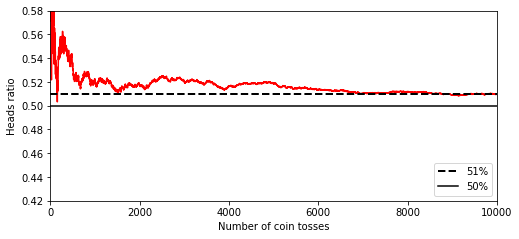

In [5]:
#%matplotlib notebook

plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio, c = 'r')
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

## Bagging and Pasting

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=0)
# bagging classifier use the same model for every estimator, train on different random subsets of training set
bag_clf = BaggingClassifier(dt_clf, n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, random_state=0)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [7]:
from  sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.88


In [8]:
bag_clf.fit(X_train, y_train)
print('Train score: {:.2f}'.format(bag_clf.score(X_train, y_train)))
print('Test score: {:.2f}'.format(bag_clf.score(X_test, y_test)))

Train score: 0.93
Test score: 0.88


In [9]:
tree_clf = DecisionTreeClassifier(random_state=0)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_tree))

0.856


In [10]:
from  matplotlib.colors  import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

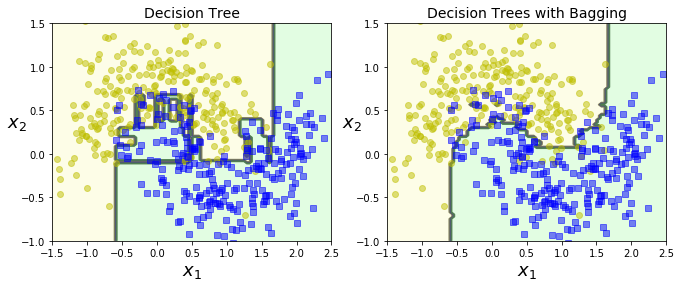

In [11]:
#%matplotlib notebook

plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()
# Risk of overfitting when using single decision tree, better generalization for decision tree with bagging

### Random Forests

In [12]:
dt_clf = DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=0)
# When max_samples is int, it means how many samples, when it is float, it means percentage of the total samples
bag_clf = BaggingClassifier(dt_clf, n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=0)

instance sampling vs feature sampling
- keep all training instances by: bootstrap=False, max_samples=1.0
- sampling features by: bootstrap_features=True and/or max_features to a value smaller than 1.0

In [13]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [14]:
from sklearn.ensemble import RandomForestClassifier
# max_leaf_nodes here actually does the sampling features
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=0)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [15]:
np.sum(y_pred == y_pred_rf ) / len(y_pred)  # almost identical predictions

0.992

In [16]:
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [17]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

#### Out-of-Bag evaluation

In [18]:
dt_clf = DecisionTreeClassifier(random_state=0)

bag_clf = BaggingClassifier(dt_clf, n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True, random_state=0)
# 37% of the instances have never been sampled, so use them for test set to check the model performance
# oob_score=True will give the score of those never sampled out-of-bag samples
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8826666666666667

In [19]:
bag_clf.oob_decision_function_[:10]

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.15168539, 0.84831461],
       [0.95375723, 0.04624277],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.47150259, 0.52849741],
       [0.48618785, 0.51381215],
       [1.        , 0.        ]])

In [20]:
from sklearn.metrics import accuracy_score

# Here the test score is generated from the sample that has been seen in the previous training process
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.848

#### Random Forest on Cancer dataset

In [21]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


In [22]:
forest.feature_importances_

array([0.02515433, 0.01563844, 0.05372655, 0.04861645, 0.00769078,
       0.00936994, 0.05539489, 0.10305394, 0.0065771 , 0.00282708,
       0.02921459, 0.00607814, 0.01342868, 0.03420174, 0.00360641,
       0.00432096, 0.00448775, 0.00657502, 0.00460597, 0.00627095,
       0.11657269, 0.01603133, 0.16027724, 0.0634688 , 0.01356448,
       0.01164113, 0.03923725, 0.11711756, 0.01164259, 0.00960721])

([<matplotlib.axis.YTick at 0x26aff8a37f0>,
 <a list of 30 Text yticklabel objects>)

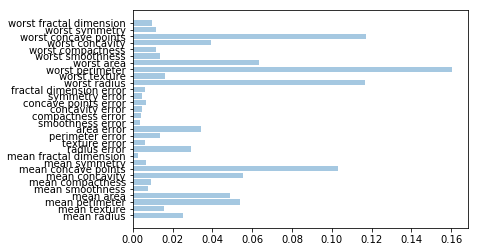

In [23]:
#%matplotlib notebook

y_list = forest.feature_importances_
y_pos = np.arange(len(y_list))
features = cancer.feature_names
plt.barh(y_pos, y_list, align='center', alpha=0.4)
plt.yticks(y_pos, features)

### AdaBoost

Focus on those miss classified instances, increase their weight in the next iteration

The problem is that it may not able to converge as it focusing on the miss classified instances, but in general, it gives back quite good result

In [24]:
from sklearn.ensemble import AdaBoostClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5, random_state=0)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=0)

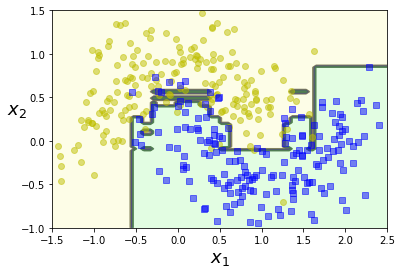

In [25]:
#%matplotlib notebook

plot_decision_boundary(ada_clf, X_train, y_train)

The learning rate is the weight you are going to assign to the miss classified instances

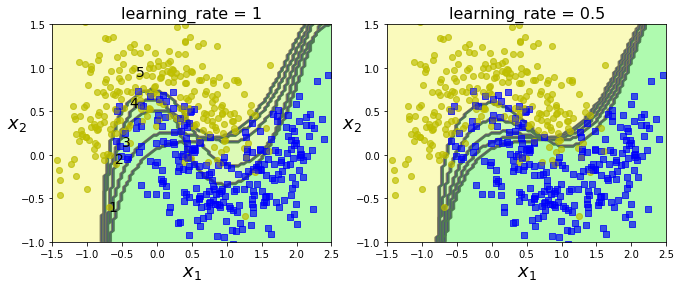

In [26]:
#%matplotlib notebook
m = len(X_train)

plt.figure(figsize=(11, 4))
for  subplot,  learning_rate  in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
plt.show()

### Gradient Boosting

In [27]:
np.random.seed(0)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [28]:
# n_estimators is the number of iterations that you are going to fit the residual
# learning_rate=0.1, means the calculated residual value will multiple by 0.1 before considered by the next iteration

In [29]:
from  sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [30]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

In [31]:
def  plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

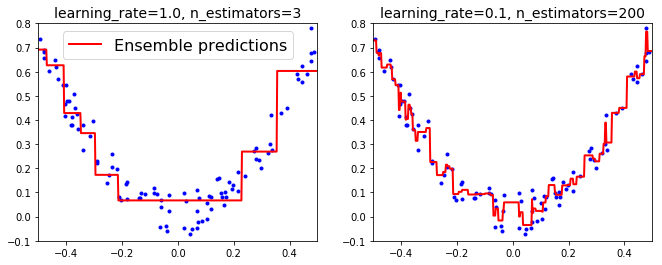

In [32]:
#%matplotlib notebook
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

#### Gradient Boosting on Cancer Dataset

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.965


In [34]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [35]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.965


<IPython.core.display.Javascript object>


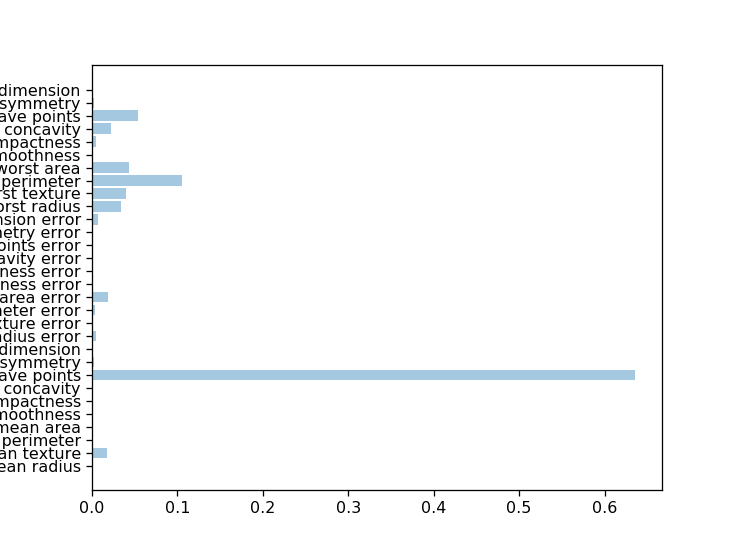

([<matplotlib.axis.YTick at 0x26aff7ceeb8>,
 <a list of 30 Text yticklabel objects>)

In [36]:
%matplotlib notebook

y_list = gbrt.feature_importances_
y_pos = np.arange(len(y_list))
features = cancer.feature_names
plt.barh(y_pos, y_list, align='center', alpha=0.4)
plt.yticks(y_pos, features)